<a href="https://colab.research.google.com/github/McMafia/ADMMBO/blob/main/ADMMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import math

In [122]:
def f1(vec):
  t=np.arctan(vec[0]/(vec[1]+1E-9))
  #return (vec[0]**2) + (vec[1]**2)-(2*np.cos(t)-0.5*np.cos(2*t)-0.25*np.cos(3*t)-0.125*np.cos(4*t))**2 -(2*np.sin(t))**2
  return np.sin(vec[0])*np.sin(vec[1])+0.95
  #return vec[0]**2 +vec[1]**2 -1.5 

In [123]:
def f2(vec):
  
  return 1.5-vec[0]-2*vec[1]-0.5*np.sin(2*math.pi*(vec[0]**2-2*vec[1]))

In [124]:
constr_func=[f1]

In [125]:
def obj_func(vec):
  #return -(np.cos((vec[0]-0.1)*vec[1]))**2- vec[0]*(np.sin(3*vec[0]+vec[1]))
  return np.sin(vec[0])+vec[1]
  #return vec[0]+vec[1]

In [126]:
class problem:
  
  def __init__(self,K,dim,n,m,delta,rho,eps,M,y1,z1,num_constraint,alpha,beta,bounds,model_opt,model_feas,F,X,C,Z):
    self.ADMM_iter=K
    self.dim=dim
    self.n=n
    self.m=m
    self.delta=delta
    self.rho=rho
    self.eps=eps
    self.M=M
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    self.num_constr=num_constraint
    self.X=X
    self.beta=beta
    self.B=bounds
    self.U=[]
    self.F=F
    self.model_opt=model_opt
    self.model_feas=model_feas
    self.C=C
    self.Z=Z


  
  def OPT(self,alpha,y1,z1,xstar):
    self.alpha=alpha
    #self.y1=np.mean(y1,axis=0)
    #self.z1=np.mean(z1,axis=0)
    
    self.U=np.zeros(self.n)
    self.U=self.U.reshape((self.n,-1))
    for i in range(self.n):
      for j in range(self.num_constr):
        self.U[i]=self.F[i]+(self.rho/2)*(np.linalg.norm(self.X[i]-self.z1[j]+self.y1[j]/self.rho))**2

    for t in range(alpha):
      self.model_opt.fit(self.X,self.U)
      Xsamples=np.random.uniform(self.B[0][0],self.B[0][1],(200,self.dim))
      Xsamples[150:200,0]=np.random.uniform(max(self.B[0][0],xstar[0]-1),min(self.B[0][1],xstar[0]+1))
      Xsamples[150:200,0]=np.random.uniform(max(self.B[1][0],xstar[0]-1),min(self.B[1][1],xstar[0]+1))
      mu,std=self.surrogate_X(self.model_opt,Xsamples)
      mu=np.array(mu)
      std=np.array(std)
      # estimate the best
      best=min(self.U)
      
      l=np.empty((0,1),float)
      probs=np.empty((0,1),float)


      for i in range(200):
        l=np.vstack((l,(best-mu[i])/(std[i]+1E-9)))
        #probs = np.vstack((probs,norm.cdf((best-mu[i]) / (std[i]+1E-9))))
        probs=np.vstack((probs,std[i]*(l[i]*norm.cdf(l[i])+norm.pdf((l[i])))))

      ix=np.argmax(probs)
      self.X=np.vstack((self.X,Xsamples[ix]))
      self.F=np.vstack((self.F,obj_func(Xsamples[ix])))
      
      self.U=np.vstack((self.U,obj_func(Xsamples[ix])+self.num_constr*(self.rho/2)*(np.linalg.norm(Xsamples[ix]-self.z1+self.y1/self.rho))**2))
      mi=min(self.F)
      
      ##############

      self.n=self.n+1


    index=np.argmin(self.U)
    return self.X[index]

  def FEAS(self,ix,xmin,y1,z1):
    H=np.zeros((self.m[ix],1))
    H.reshape((self.m[ix],-1))
    self.y1=y1
 
   
    for i in range(self.m[ix]):
      H[i]=int(self.C[ix][i]>0)+(self.rho/(2*self.M))*(np.linalg.norm(xmin-self.Z[ix][i]+self.y1[ix]/self.rho))**2
    
    hplus=min(H)
    #print(H)
    for t in range(self.beta[ix]):
      self.model_feas[ix].fit(self.Z[ix][0:self.m[ix]],self.C[ix][0:self.m[ix]])
      Zsamples=np.random.uniform(self.B[0][0],self.B[0][1],(200,self.dim))
      Zsamples[150:200,0]=np.random.uniform(max(self.B[0][0],xmin[0]-1),min(self.B[0][1],xmin[0]+1))
      Zsamples[150:200,0]=np.random.uniform(max(self.B[1][0],xmin[0]-1),min(self.B[1][1],xmin[0]+1))
      mu,std=self.surrogate_Z(self.model_feas[ix],Zsamples)
      
      theta=np.zeros(200)
      theta.reshape((200,-1))
      
      probs=np.zeros(200)
      
      for i in range(200):
        
        theta[i] = 1-norm.cdf(-mu[i]/std[i])
        
        if hplus - (self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2 <= 0:
          probs[i]=0
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2>0 and hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2<=1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2)*(1-theta[i])
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2>1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2)*(1-theta[i])+theta[i]*(hplus-1-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1[ix]/self.rho))**2)

      idx=np.argmax(probs)
      #print(theta)
      Zsamples=Zsamples.reshape(200,2)

      self.Z[ix][self.m[ix]]=Zsamples[idx]
      h=int(constr_func[ix](Zsamples[idx]>0))+(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[idx]+self.y1[ix]/self.rho))**2

      H=np.vstack((H,np.array([h])))
      hplus=min(H)
      self.C[ix][self.m[ix]]=constr_func[ix](Zsamples[idx])

      self.m[ix]=self.m[ix]+1

    zmin=np.argmin(H)
      
    zmin=(self.Z[ix][zmin])
    return zmin  

  def surrogate_X(self,model, X):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(X, return_std=True)
    
  def surrogate_Z(self,model, Zsamples):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(Zsamples, return_std=True)
    
  def concat(self):

    for i in range(self.num_constr):
      self.X=np.concatenate((self.X,self.Z[i]),axis=0)
      for j in range(len(self.Z[i])):
        self.F=np.vstack((self.F,obj_func(self.Z[i][j])))



    
      

In [127]:
def ADMMBO(dim,n,N,K,bound):
  
  dim=dim
  n=n
    
  m=np.full(N,4)
  
  K=K
  delta=0.05
  rho=0.1
  eps=0.01
  M=200
  
  bound=bound
  S=False

  y1=np.full((N,dim),2.0)
  z1=np.full((N,dim),2.0)
  

  model_opt = GaussianProcessRegressor()
  model_feas=[GaussianProcessRegressor() for i in range(N)]
  
  alpha=np.random.randint(2,5,K)
  alpha[0]=20
  beta=np.random.randint(2,5,N)
  beta[0]=20
  
  

  F=np.zeros(n)
  F=F.reshape((n,-1))
  X = np.zeros((n,dim))
  C=np.zeros((N, np.max(m)+np.max(beta)*K))
  Z = np.zeros((N, np.max(m)+K*np.max(beta), dim))

  ##Create an instance
  prob=problem(K,dim,n,m,delta,rho,eps,M,y1,z1,N,alpha,beta,bound,model_opt,model_feas,F,X,C,Z)

  for i in range(prob.num_constr):
    for j in range(prob.m[i]):
      prob.Z[i][j]=np.random.uniform(bound[i][0],bound[i][1],size=(dim))
      prob.C[i][j]=constr_func[i](Z[i][j])
  answers=np.zeros((K+1,dim))
  
  for i in range(n):
    prob.X[i]=(np.random.uniform(bound[0][0],bound[0][1],prob.dim))
    prob.F[i]=obj_func(prob.X[i])
  
  k=0

  r=np.full((N,2),1e9)
  s=np.full((N,2),1e9)
  mini=1e9+0.1
  zprev=np.zeros(z1.shape)
  xstar=np.array([0.0,0.0])
  while k<prob.ADMM_iter and S==False:
    print(k)
    xstar=prob.OPT(alpha[k],y1,z1,xstar)
    #print(prob.model_feas[1].predict([[0,0],[0.2,0.4]]))
    for i in range(prob.num_constr):
      
      
      z1[i]=prob.FEAS(i,xstar,y1,z1)
      y1[i]=y1[i]+prob.rho*(xstar-z1[i])
      
      #print(y1[0])
      r[i]=xstar-z1[i]
      s[i]=-prob.rho*(z1[i]-zprev[i])
      zprev[i]=z1[i]
      
                      
    #print(np.linalg.norm(r),np.linalg.norm(s),xstar)
    if np.linalg.norm(r) <=prob.eps and np.linalg.norm(s) <=prob.eps:
      S=True
    k=k+1   
    if(np.linalg.norm(r)>=np.linalg.norm(s)*10):
      prob.rho=2.0*prob.rho

    if(np.linalg.norm(s)>=np.linalg.norm(r)*10):
      prob.rho=prob.rho/2.0
    
    answers[k]=xstar
  #  print(xstar,obj_func(xstar))
    if(constr_func[i](xstar)<=0):
      print(obj_func(xstar),'yesssssssss')
    
    

      
   
    if S==True:
      print(xstar,obj_func(xstar),"answer is here!!!!!")    
    
  plt.scatter(answers[:,0],answers[:,1])    
  if S == False:
    mini=1E12+0.01
   
    prob.concat()
 
    for i in range(prob.X.size//2):
      ans=1
      for j in range(prob.num_constr):
        mu,std=prob.surrogate_Z(model_feas[j],[prob.X[i]])
       
        ans=ans and int(norm.cdf(-mu/std)>=1-delta)
      if ans==1 and prob.F[i]<=mini:
       
        xstar=prob.X[i]
        mini=prob.F[i]
    print(xstar,mini)   
  

  


0
7.495522782506002 0.7627317168593029 [0.00807189 0.17706851]
1
4.9634452571647865 0.38221784462339375 [0.13236163 0.01883191]
2
5.157781050544753 0.8865795540685248 [0.13236163 0.01883191]
3
4.7051730062244035 0.8525339017172054 [0.00807189 0.17706851]
4
1.2055917300039458 0.06579642956375925 [4.80975312 0.1350886 ]
5
1.2590348695057594 0.02856191665041349 [4.62804287 0.00521505]
6
0.4594787545099792 0.0 [4.72273172 0.81015097]
7
0.1714172711644974 0.0 [4.82165662 1.24541805]
8
0.14100341217286136 0.0 [4.60471686 1.39713859]
0.4029296338739691 yesssssssss
9
0.09886076731988966 0.0 [4.59733129 1.18117549]
10
0.03291206743547405 0.0 [4.6235732  1.28184073]
0.2857822628903317 yesssssssss
11
0.03226677557113138 1.592178641261949 [4.6235732  1.28184073]
0.2857822628903317 yesssssssss
12
0.03291206743547405 0.7960893206309745 [4.6235732  1.28184073]
0.2857822628903317 yesssssssss
13
0.03226677557113138 0.39804466031548724 [4.6235732  1.28184073]
0.2857822628903317 yesssssssss
14
0.09886076

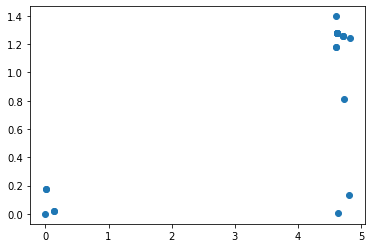

In [140]:
N=1
dim=2
n=4
K = 20
bound=[(0,6),(0,6)]
#bound=[(-2.25,2.5),(-2.5,1.75)]
ADMMBO(dim,n,N,K,bound)